# Scoring and FDR calculation with Sagepy

The following notebook contains a basic scoring example with `sagepy`. You will:

* Create a Sage peptide reference database with decoys from a .fasta file
* Read in an mzML file from a DDA LC-MS-MS dataset and extract precursor information as well as fragment spectra
* Score the raw data and compare scores of target and decoy hits
* Calculate False Discovery Rate (FDR) q-values for each PSM using Target Decoy Competition (TDC)

The tutorial was tested with raw data from the [proteometools dataset](http://www.proteometools.org/) and used the [ThermoRawFileParser](https://github.com/compomics/ThermoRawFileParser) to translate .raw files zo mzML, but feel free to use any thermo LC-MS-MS raw data stored as mzML.

## Create a sage reference database

In [83]:
import pandas as pd

from sagepy.utility import create_sage_database

fasta_path = "/path/to/proteome.fasta"

# for simplicity, we can use the create_sage_database function, that creates a sage indexed database with tryptic settings
indexed_database = create_sage_database(
    fasta_path = fasta_path,
)

## Read an mzML file

In [84]:
from sagepy.utility import extract_mzml_data

mzml_path = "/path/to/dda/raw/data.mzML"

# this function expects thermo data and was tested with proteome tools datasets
dda_data = extract_mzml_data(
    file_path=mzml_path
)

## Create a Sage Scorer and Score a collection of spectra

In [85]:
from sagepy.core import Scorer

scorer = Scorer(report_psms=5, min_matched_peaks=5)

# the scorer returns a dict of type PeptideSpectrumMatch, an object that holds information about the PSM
# where the types are Dict[spec_id -> List[PSM]]
results = scorer.score_collection_psm(db=indexed_database, spectrum_collection=dda_data.processed_spec.values, num_threads=12)

## Create a pandas table holding all PSMs found during the DB search

In [86]:
from sagepy.utility import peptide_spectrum_match_list_to_pandas

# To create a pandas table from the scorers return, we need to flatten the PSM dict into a list of results
psm_list = []

for _, values in results.items():
    psm_list.extend(values)

# this helper function creates a pandas table from a list of PSM objects
PSM_pandas = peptide_spectrum_match_list_to_pandas(psm_list)

## Plot the scores for target and decoy hits

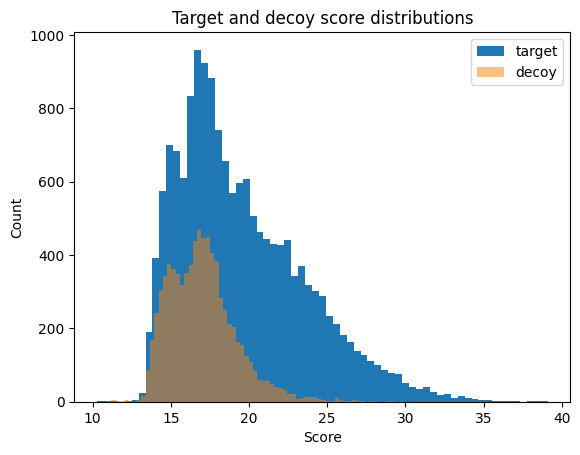

In [87]:
from matplotlib import pyplot as plt

TARGET = PSM_pandas[PSM_pandas.decoy == False]
DECOY = PSM_pandas[PSM_pandas.decoy]

plt.hist(TARGET.hyper_score, bins="auto", label="target")
plt.hist(DECOY.hyper_score, bins="auto", alpha=.5, label="decoy")
plt.legend()
plt.title("Target and decoy score distributions")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

## Target Decoy Competition (TDC) for False Discovery Rate (FDR) estimation

It is common to use the generated raw scores from the PSMs as a test statistic, transforming the raw scores into q-values. If you are unfamiliar with this concept, there are [several resources](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/pmic.202300084?af=R) and [publications](https://pubs.acs.org/doi/full/10.1021/acs.jproteome.7b00170) available that help to understand how false discovery rates are calculated in high-throughput proteomics.

In [88]:
from sagepy.qfdr.tdc import target_decoy_competition_pandas

TDC = target_decoy_competition_pandas(
    df=PSM_pandas,
    # the method for TDC can be set here, e.g., PSM level, peptide level, or double competition (PSM and peptide level)
    method="psm",
    score="hyper_score"
)

# after target decoy competition, hits can be filtered to, e.g., 1 percent expected FDR == q-value <= 0.01
TDC_filtered = TDC[(TDC.q_value <= 0.01) & (TDC.decoy == False)]

## Create merged result table, filtered to target FDR with TDC method of choice

In [89]:
import pandas as pd
RESULT = pd.merge(PSM_pandas.drop(columns=["q_value", "decoy", "match_idx", "score"]), TDC_filtered, on="spec_idx")
RESULT

,spec_idx,proteins,re_score,hyper_score,rank,mono_mz_calculated,mono_mass_observed,mono_mass_calculated,delta_mass,isotope_error,...,mean_ppm,median_ppm,fragments_observed,fragments_predicted,projected_rt,beta_score,match_idx,decoy,score,q_value
0,controllerType=0 controllerNumber=1 scan=10000,[sp|Q5DID0|UROL1_HUMAN],None,30.235552,1,492.759094,983.504639,983.503601,-0.001038,3.01005,...,-0.112941,0.950233,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,ELQQVDPR,False,30.235552,0.002653
1,controllerType=0 controllerNumber=1 scan=10018,[sp|Q9H489|TSY26_HUMAN],None,29.204351,1,461.255646,920.498535,920.496704,-0.001831,1.00335,...,2.424821,1.763269,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,EEGAIFKK,False,29.204351,0.004545
2,controllerType=0 controllerNumber=1 scan=10042,[sp|O00445|SYT5_HUMAN],None,28.558388,1,426.258514,850.504700,850.502502,-0.002197,3.01005,...,0.295653,1.081173,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,VHLLQGGK,False,28.558388,0.005168
3,controllerType=0 controllerNumber=1 scan=10232,[sp|Q8IZU3|SYCP3_HUMAN],None,27.455831,1,470.749664,939.485168,939.484802,-0.000366,1.00335,...,-0.872877,0.401957,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,RLEMYTK,False,27.455832,0.005168
4,controllerType=0 controllerNumber=1 scan=10278,[sp|P50914|RL14_HUMAN],None,28.228112,1,431.748322,861.483154,861.482056,-0.001099,-1.00335,...,1.780106,1.652575,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,RFVEVGR,False,28.228111,0.005168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,controllerType=0 controllerNumber=1 scan=9878,[sp|Q5DID0|UROL1_HUMAN],None,30.383914,1,492.759094,983.504883,983.503601,-0.001282,1.00335,...,1.579518,2.154571,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,ELQQVDPR,False,30.383913,0.002653
995,controllerType=0 controllerNumber=1 scan=9882,[sp|Q9H489|TSY26_HUMAN],None,27.954155,1,461.255646,920.500000,920.496704,-0.003296,0.00000,...,1.809719,1.500605,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,EEGAIFKK,False,27.954155,0.005168
996,controllerType=0 controllerNumber=1 scan=9934,[sp|O00445|SYT5_HUMAN],None,29.487092,1,426.258514,850.504456,850.502502,-0.001953,3.01005,...,1.954460,1.744362,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,VHLLQGGK,False,29.487091,0.002653
997,controllerType=0 controllerNumber=1 scan=9936,[sp|P59768|GBG2_HUMAN],None,27.079430,1,429.276367,856.540039,856.538208,-0.001831,1.00335,...,1.469928,1.287314,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,KLVEQLK,False,27.079430,0.007084
